# Code for retaining seasonality in netCDF data

`average_time=False` to preserve time dimension to allow xarray's grouping by time to work

In [1]:
### Import packages

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import numpy as np
import matplotlib.path as mpath
import os
import cmocean

In [2]:
# Plot temperature

def plot_global_maps(dataarrays, titles=None, cmap="coolwarm", vmin=None, vmax=None, suptitle=None):
    """
    Plot one or more global maps side-by-side (North Polar projection).
    
    Parameters
    ----------
    dataarrays : xarray.DataArray or list of xarray.DataArray
        One or multiple DataArrays to plot.
    titles : list of str or str, optional
        Titles for each subplot. Must match number of dataarrays if list.
    cmap : str
        Colormap name.
    vmin, vmax : float, optional
        Color scale limits.
    """
    # Ensure input is a list
    if not isinstance(dataarrays, (list, tuple)):
        dataarrays = [dataarrays]
    n = len(dataarrays)

    # Handle titles
    if titles is None:
        titles = [""] * n
    elif isinstance(titles, str):
        titles = [titles] * n

    # Create subplots
    fig, axes = plt.subplots(
        1, n,
        figsize=(5 * n, 5),
        subplot_kw={"projection": ccrs.NorthPolarStereo()}
    )

    # Handle single subplot case
    if n == 1:
        axes = [axes]

    def add_circle_boundary(ax):
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)

    # Plot each map
    for ax, da, title in zip(axes, dataarrays, titles):
        im = da.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False
        )
        ax.coastlines()
        ax.set_extent([-180, 180, 90, 40], crs=ccrs.PlateCarree())
        add_circle_boundary(ax)
        ax.set_title(title, fontsize=12)

    # Shared colorbar
    cbar = fig.colorbar(im, ax=axes, orientation="horizontal", fraction=0.05, pad=0.07)
    cbar.set_label("Temperature (K)")

     # Add suptitle
    if suptitle:
        fig.suptitle(suptitle, fontsize=16, y=1.02)

    # plt.tight_layout()

In [3]:
# Plot MSLP

def plot_global_maps_mslp(
    dataarrays,
    titles=None,
    cmap="cmocean.delta",      # diverging scheme centered at 0
    vmin=-2, vmax=2,    # small anomaly range (hPa)
    suptitle=None,
    contour_interval=0.25,  # isobar interval (in hPa)
):
    """
    Plot one or more global PSL anomaly maps side-by-side (North Polar projection)
    with isobars (contour lines).

    Parameters
    ----------
    dataarrays : xarray.DataArray or list of DataArrays
        PSL anomaly fields (e.g. differences relative to 1920–1940 baseline).
    titles : list of str or str, optional
        Titles for each subplot.
    cmap : str
        Colormap for anomalies (default: 'RdBu_r').
    vmin, vmax : float
        Color limits for anomaly magnitude (in hPa).
    suptitle : str, optional
        Title for the whole figure.
    contour_interval : float
        Interval between isobars (in hPa).
    """
    # Ensure input is a list
    if not isinstance(dataarrays, (list, tuple)):
        dataarrays = [dataarrays]
    n = len(dataarrays)

    # Handle titles
    if titles is None:
        titles = [""] * n
    elif isinstance(titles, str):
        titles = [titles] * n

    # Create subplots
    fig, axes = plt.subplots(
        1, n,
        figsize=(5 * n, 5),
        subplot_kw={"projection": ccrs.NorthPolarStereo()}
    )

    if n == 1:
        axes = [axes]

    def add_circle_boundary(ax):
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)

    for ax, da, title in zip(axes, dataarrays, titles):
        # Ensure units in hPa (convert if needed)
        if da.attrs.get("units", "").lower() == "pa":
            da = da / 100
            da.attrs["units"] = "hPa"

        # Filled contour (anomaly field)
        im = da.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False,
        )

        # Overlay isobars (every contour_interval hPa)
        levels = np.arange(vmin, vmax + contour_interval, contour_interval)
        cs = ax.contour(
            da["lon"], da["lat"], da,
            levels=levels,
            colors="black",
            linewidths=0.6,
            alpha=0.6,
            transform=ccrs.PlateCarree(),
        )
        ax.clabel(cs, fmt="%.1f", fontsize=7)

        # Map details
        ax.coastlines()
        ax.set_extent([-180, 180, 90, 40], crs=ccrs.PlateCarree())
        add_circle_boundary(ax)
        ax.set_title(title, fontsize=12)

    # Shared colorbar
    cbar = fig.colorbar(im, ax=axes, orientation="horizontal", fraction=0.05, pad=0.07)
    cbar.set_label("Pressure (hPa)")

    # Suptitle
    if suptitle:
        fig.suptitle(suptitle, fontsize=16, y=1.05)

In [4]:
# Load .nc

def compute_ensemble_data(
    base_path,
    var="TREFHT",
    start_year="1920",
    end_year="1940",
    engine="netcdf4",
    average_time=True
):
    """
    Compute ensemble mean for a given variable and time period,
    optionally preserving the time dimension (for seasonal analysis).
    """
    all_files = sorted(glob.glob(os.path.join(base_path, "*.nc")))
    if not all_files:
        raise FileNotFoundError(f"No .nc files found in {base_path}")

    member_ids = sorted(set([os.path.basename(f).split('.')[6] for f in all_files]))

    def per_member_data(member_files):
        ds = xr.open_mfdataset(
            member_files,
            combine="by_coords",
            engine=engine,
            compat="override",
            coords="minimal",
        )[[var]]
        da = ds[var].sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
        if average_time:
            da = da.mean(dim="time")
        arr = da.compute()
        ds.close()
        return arr

    member_data = [per_member_data([f for f in all_files if f".{mid}." in os.path.basename(f)]) for mid in member_ids]
    ensemble_mean = xr.concat(member_data, dim="member").mean(dim="member")
    return ensemble_mean

In [5]:
# Function to save model components (AAER, LE-xAER, LE-xAER-AAER, GHG) to new file location whilst preserving seasonality

def compute_seasonal_nonlinearity(var, base_dirs, baseline_period=("1920", "1940"), compare_period=("1965", "1985"), engine="netcdf4"):
    """
    Compute seasonal nonlinearities ((LE - xAER) - AAER) per season.
    """
    # Load ensemble mean timeseries (no time averaging yet)
    def load(path, start, end):
        return compute_ensemble_data(path, var, start, end, engine, average_time=False)

    # Load baseline & comparison data
    base_LE   = load(base_dirs["LE"], *baseline_period)
    base_AAER = load(base_dirs["AAER"], *baseline_period)
    base_xAER = load(base_dirs["xAER"], *baseline_period)
    base_GHG  = load(base_dirs["GHG"], *baseline_period)

    comp_LE   = load(base_dirs["LE"], *compare_period)
    comp_AAER = load(base_dirs["AAER"], *compare_period)
    comp_xAER = load(base_dirs["xAER"], *compare_period)
    comp_GHG  = load(base_dirs["GHG"], *compare_period)

    # Compute anomalies relative to baseline climatology (per season)
    base_LE_seasonal   = base_LE.groupby("time.season").mean("time")
    base_AAER_seasonal = base_AAER.groupby("time.season").mean("time")
    base_xAER_seasonal = base_xAER.groupby("time.season").mean("time")
    base_GHG_seasonal  = base_GHG.groupby("time.season").mean("time")

    comp_LE_seasonal   = comp_LE.groupby("time.season").mean("time")
    comp_AAER_seasonal = comp_AAER.groupby("time.season").mean("time")
    comp_xAER_seasonal = comp_xAER.groupby("time.season").mean("time")
    comp_GHG_seasonal  = comp_GHG.groupby("time.season").mean("time")

    # Compute anomalies per season
    aaer_anom = comp_AAER.groupby("time.season").mean("time") - base_AAER_seasonal
    xaer_anom = comp_xAER.groupby("time.season").mean("time") - base_xAER_seasonal
    le_anom   = comp_LE.groupby("time.season").mean("time") - base_LE_seasonal
    ghg_anom  = comp_GHG.groupby("time.season").mean("time") - base_GHG_seasonal

    # Align and compute nonlinear term
    aaer_aligned, xaer_aligned, le_aligned, ghg_aligned = xr.align(aaer_anom, xaer_anom, le_anom, ghg_anom, join="override")

    le_minus_xaer = le_aligned - xaer_aligned
    nonlinear = le_minus_xaer - aaer_aligned

    # Return dictionary of seasonal fields
    return {"AAER": aaer_aligned, "LE_minus_xAER": le_minus_xaer, "Nonlinear": nonlinear, "GHG": ghg_aligned}

In [11]:
# Define paths (adjust to directory structure)
paths_TREFHT = {
    "LE": "TREFHT/LE/",
    "AAER": "TREFHT/AAER/",
    "xAER": "TREFHT/xAER/",
    "GHG": "TREFHT/GHG/"
}

results = compute_seasonal_nonlinearity(
    var="TREFHT",
    base_dirs=paths_TREFHT,
    baseline_period=("1920", "1939"),
    compare_period=("1965", "1985")
)

for key, da in results.items():
    for season in ["DJF", "MAM", "JJA", "SON"]:
        ds = da.sel(season=season).to_dataset(name="TREFHT")
        out_path = f"nonlinear_outputs10/{key}_TREFHT_1965-1985_{season}.nc"
        ds.to_netcdf(out_path)
        print(f" Saved {out_path}")

 Saved nonlinear_outputs10/AAER_TREFHT_1965-1985_DJF.nc
 Saved nonlinear_outputs10/AAER_TREFHT_1965-1985_MAM.nc
 Saved nonlinear_outputs10/AAER_TREFHT_1965-1985_JJA.nc
 Saved nonlinear_outputs10/AAER_TREFHT_1965-1985_SON.nc
 Saved nonlinear_outputs10/LE_minus_xAER_TREFHT_1965-1985_DJF.nc
 Saved nonlinear_outputs10/LE_minus_xAER_TREFHT_1965-1985_MAM.nc
 Saved nonlinear_outputs10/LE_minus_xAER_TREFHT_1965-1985_JJA.nc
 Saved nonlinear_outputs10/LE_minus_xAER_TREFHT_1965-1985_SON.nc
 Saved nonlinear_outputs10/Nonlinear_TREFHT_1965-1985_DJF.nc
 Saved nonlinear_outputs10/Nonlinear_TREFHT_1965-1985_MAM.nc
 Saved nonlinear_outputs10/Nonlinear_TREFHT_1965-1985_JJA.nc
 Saved nonlinear_outputs10/Nonlinear_TREFHT_1965-1985_SON.nc
 Saved nonlinear_outputs10/GHG_TREFHT_1965-1985_DJF.nc
 Saved nonlinear_outputs10/GHG_TREFHT_1965-1985_MAM.nc
 Saved nonlinear_outputs10/GHG_TREFHT_1965-1985_JJA.nc
 Saved nonlinear_outputs10/GHG_TREFHT_1965-1985_SON.nc


<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3379/3568233993.py:10: SyntaxWarning: invalid escape sequence '\d'
  suptitle="T$_{s}$ 10 member anomaly $40\degree$N to $90\degree$N ("f"{season}, 1965-1985)",


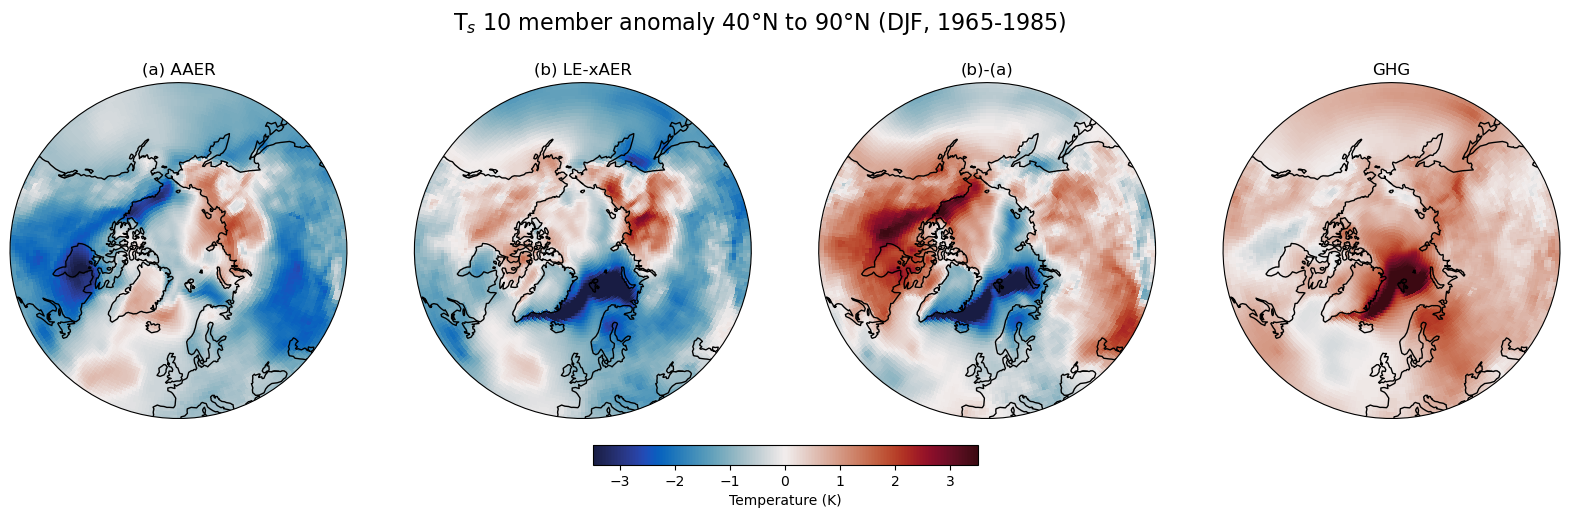

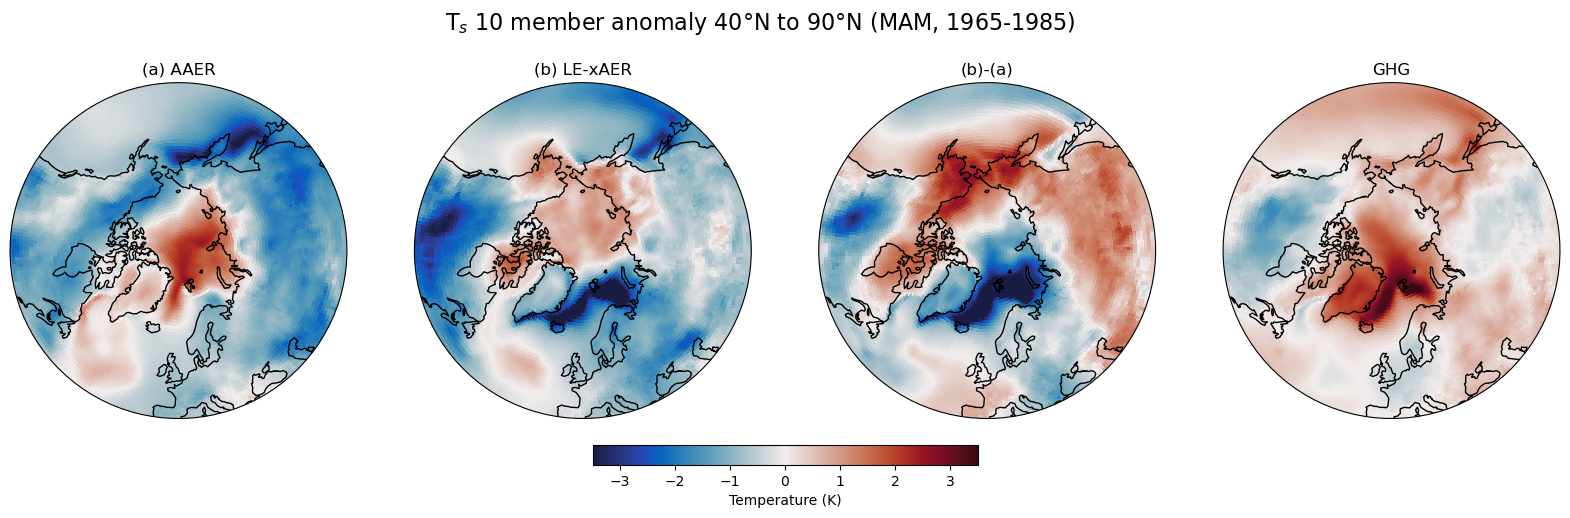

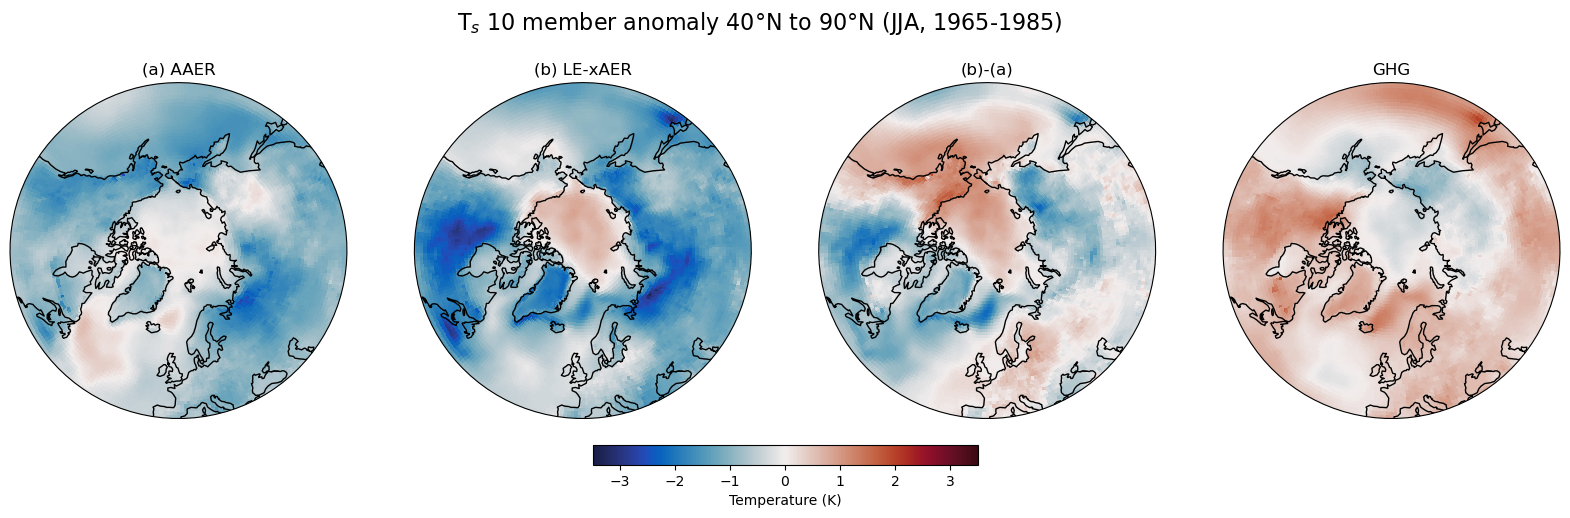

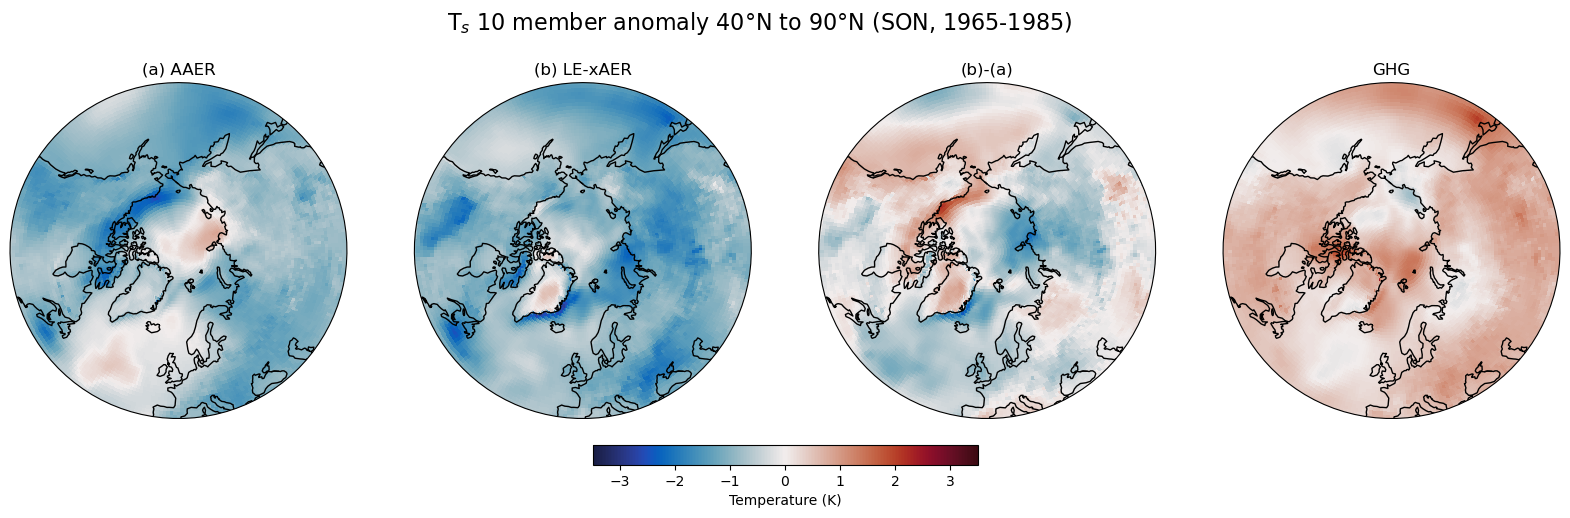

In [12]:
for season in ["DJF", "MAM", "JJA", "SON"]:
    aaer = xr.open_dataset(f"nonlinear_outputs10/AAER_TREFHT_1965-1985_{season}.nc")["TREFHT"]
    lexaer = xr.open_dataset(f"nonlinear_outputs10/LE_minus_xAER_TREFHT_1965-1985_{season}.nc")["TREFHT"]
    nonlinear = xr.open_dataset(f"nonlinear_outputs10/Nonlinear_TREFHT_1965-1985_{season}.nc")["TREFHT"]
    ghg = xr.open_dataset(f"nonlinear_outputs10/GHG_TREFHT_1965-1985_{season}.nc")["TREFHT"]

    plot_global_maps(
        [aaer, lexaer, nonlinear, ghg],
        titles=["(a) AAER", "(b) LE-xAER", "(b)-(a)", "GHG"],
        suptitle="T$_{s}$ 10 member anomaly $40\degree$N to $90\degree$N ("f"{season}, 1965-1985)",
        cmap=cmocean.cm.balance,
        vmin = -3.5,
        vmax = 3.5
    )
    plt.savefig(f"TREFHT/TREFHT_{season}_1965-1985.png", bbox_inches="tight")